# Interpretability analysis CIFAR10

## Installation of needed libraries

In [1]:
from IPython.display import clear_output
!pip install build
try:
    import pytorch_trainers_interpretability
except:
    !cd .. && python -m build
    clear_output()
    !pip install --force --upgrade ../dist/pytorch_trainers_interpretability-0.0.1-py3-none-any.whl
    !pip install torchmetrics[image] tqdm
clear_output()
try:
    import pytorch_trainers_interpretability
except:
    raise Exception("Packages not installed! Please try again!")
print("Installation completed!")

Installation completed!


## Import libraries

In [2]:
import torch
from pytorch_trainers_interpretability.interpretability_eval import IntegratedGrad, ShapEval, RepVisualization
from pytorch_trainers_interpretability.tools import show_image_column
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
from pytorch_trainers_interpretability.interpretability_eval.integrated_grad import IntegratedGrad
from pytorch_trainers_interpretability.models.resnet_cifar import ResNet18_cifar
from torchvision import transforms
import torchvision
import os
from torchmetrics.image.fid import NoTrainInceptionV3
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

## Downloading models

In [3]:
if not os.path.isfile("./standard_cifar10.pt"):
    !python gdownload.py "1--6YSHDUNcwXvnjUgjdOcV_A3bMcHEbD" "standard_cifar10.pt"
if not os.path.isfile("./robust_l2_cifar10.pt"):
    !python gdownload.py "1OcvlvVlsC1oMIzZedvf3Zh6Q10kKzoyN" "robust_l2_cifar10.pt"

2731it [00:10, 262.91it/s, size=85.34MB]
2731it [00:10, 263.05it/s, size=85.34MB]


## Loading dataset

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor()])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=True)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                         shuffle=True)

normalizer = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Loading models

In [5]:
model = ResNet18_cifar()
model2 = ResNet18_cifar()
model.load_state_dict(torch.load("./standard_cifar10.pt")["model_state_dict"])
model2.load_state_dict(torch.load("./robust_l2_cifar10.pt")["model_state_dict"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model2.to(device)
model.eval()
model2.eval()
vis = RepVisualization(model, normalizer=normalizer)
vis2 = RepVisualization(model2, normalizer=normalizer)

## Representation Inversion


In [6]:
images, labels =  next(iter(testloader))

100%|██████████| 10000/10000 [01:50<00:00, 90.46it/s, loss=0.0678]


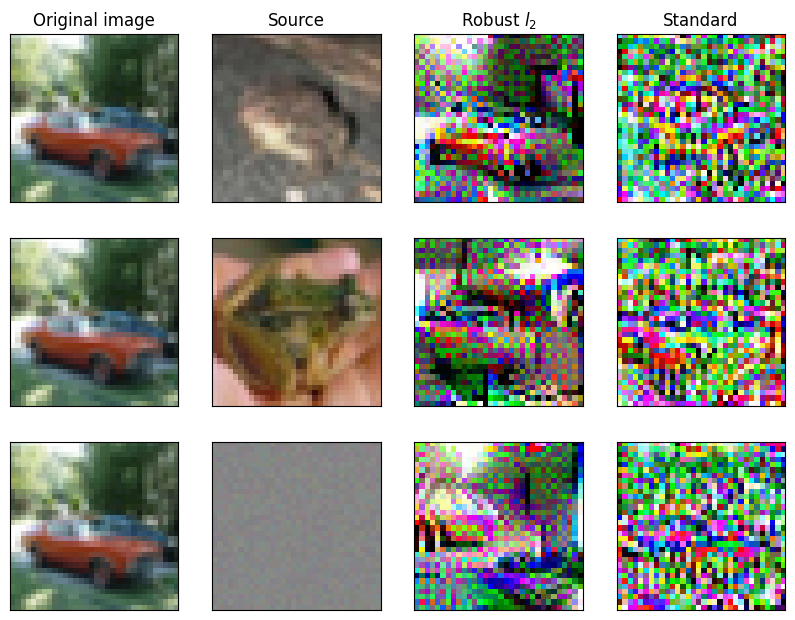

In [7]:
im = torch.concat([images[3:4] for i in range(3)])
r = torch.rand_like(images[0:1])/20 + 0.5
im_n = torch.concat([images[0:2], r], 0)
res = [im.cpu(), im_n.cpu()]
res.append(vis2.rep_inversion(im, im_n.clone()).cpu())
res.append(vis.rep_inversion(im, im_n.clone()).cpu())
show_image_column(res, ["Original image", "Source", r"Robust $l_{2}$", "Standard"])

In [8]:
inc = NoTrainInceptionV3("inc",features_list=["192"]).cuda()
d1 = inc(transforms.Resize((299, 299))((im*255).type(torch.uint8).cuda()))
d2 = inc(transforms.Resize((299, 299))((res[2]*255).type(torch.uint8).cuda()))
d3 = inc(transforms.Resize((299, 299))((res[3]*255).type(torch.uint8).cuda()))
print("L2 model")
print(f"L2 distnace: {round(torch.norm(d2-d1, p=2).cpu().item(), 2)}")
print("Standard model")
print(f"L2 distnace: {round(torch.norm(d3-d1, p=2).cpu().item(), 2)}")

L2 model
L2 distnace: 20.89
Standard model
L2 distnace: 26.24


## Class Specific Image Generation

In [9]:
GRAIN = 4
DATA_SHAPE = 32
def downsample(x, step=GRAIN):
    down = torch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = torch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

im_test, targ_test = [], []
for _, (im, targ) in enumerate(testloader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = torch.cat(im_test), torch.cat(targ_test)
im_test2, targ_test2 = [], []
for _, (im, targ) in enumerate(trainloader):
    im_test2.append(im)
    targ_test2.append(targ)
im_test2, targ_test2 = torch.cat(im_test2), torch.cat(targ_test2)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


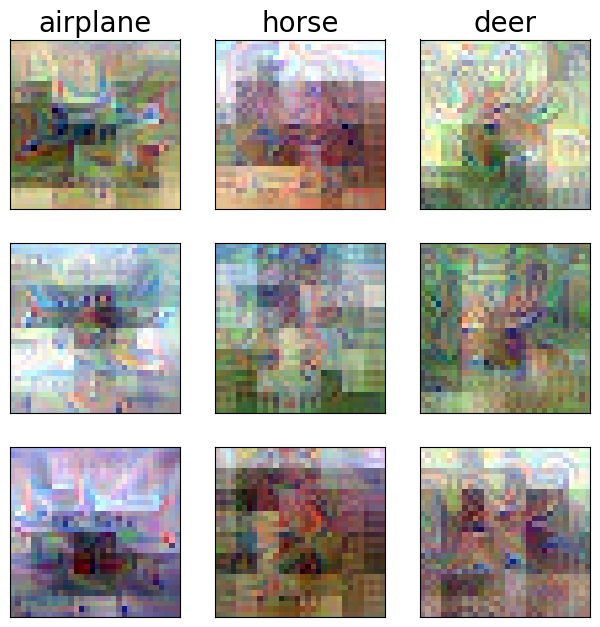

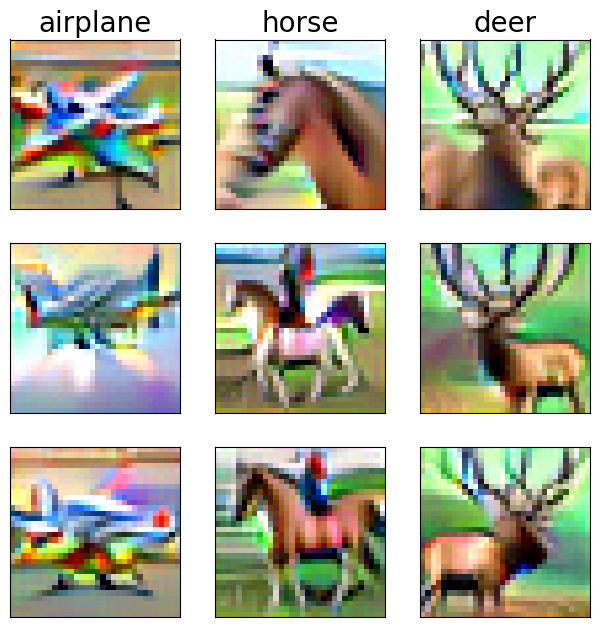

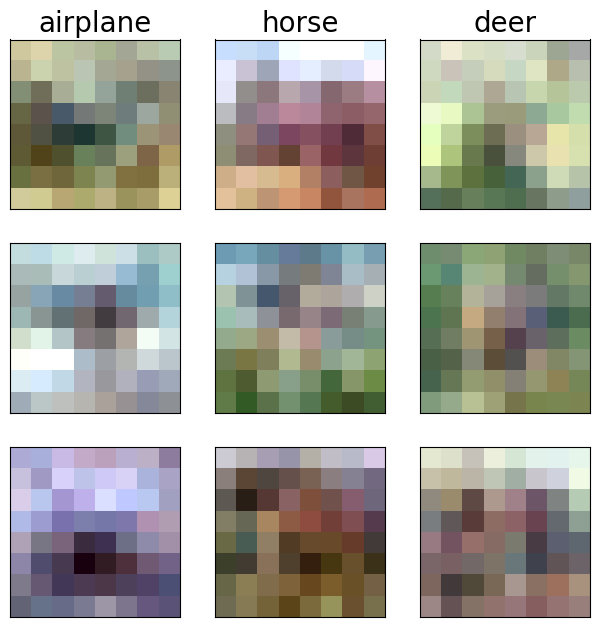

In [10]:
res = []
res2 = []
res3 = []
cl = np.random.choice(10, size=(3, ), replace=False)
for j in tqdm(range(len(cl))):
        imc = im_test[targ_test == int(cl[j])]
        down_flat = downsample(imc).view(len(imc), -1)
        mean = down_flat.mean(dim=0)
        down_flat = down_flat - mean.unsqueeze(dim=0)
        cov = down_flat.t() @ down_flat / len(imc)
        dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov+1e-4*torch.eye(int(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN)))
        img_seed = torch.cat([dist.sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN).unsqueeze(0) for p in range(3)])
        img_seed = upsample(torch.clamp(img_seed, min=0, max=1))
        res3.append(img_seed)
        res.append(vis.class_im_gen(img_seed, int(cl[j]), tqdm=False, num_iter=60, epsilon=30, lr=0.5).cpu())
        res2.append(vis2.class_im_gen(img_seed, int(cl[j]), tqdm=False, num_iter=60, epsilon=30, lr=0.5).cpu())
list_labels = [classes[int(cl[i])] for i in range(len(cl))]
show_image_column(res, list_labels, fontsize=20)
show_image_column(res2, list_labels, fontsize=20)
show_image_column(res3, list_labels, fontsize=20)

## FID score on class specific generated images


In [11]:
fid1 = FrechetInceptionDistance().to(device)
fid2 = FrechetInceptionDistance().to(device)
fid3 = FrechetInceptionDistance().to(device)
resize = transforms.Resize((299, 299))
itert = tqdm(range(10))
for i in itert:
    imc = im_test[targ_test == i]
    imc2 = im_test2[targ_test2 == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov+1e-4*torch.eye(int(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN)))
    for k in range(50, 1001, 50):
        imgc = imc[k-50:k]
        img_seed = torch.cat([dist.sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN).unsqueeze(0) for p in range(50)])
        img_seed = upsample(torch.clamp(img_seed, min=0, max=1))
        fid1.update(resize((imgc*255).type(torch.uint8)).to(device), real=True)
        fid2.update(resize((imgc*255).type(torch.uint8)).to(device), real=True)
        fid3.update(resize((imgc*255).type(torch.uint8)).to(device), real=True)
        img_g = vis.class_im_gen(img_seed, i, tqdm=False, num_iter=60, epsilon=30, lr=0.5).cpu()
        img_g2 = vis2.class_im_gen(img_seed, i, tqdm=False, num_iter=60, epsilon=30, lr=0.5).cpu()
        fid1.update(resize((img_g*255).type(torch.uint8)).to(device), real=False)
        fid2.update(resize((img_g2*255).type(torch.uint8)).to(device), real=False)
        fid3.update(resize((imc2[k-50:k]*255).type(torch.uint8)).to(device), real=False)
print(f"Standard model: {round(fid1.compute().cpu().item(), 2)}")
print(f"L2 model: {round(fid2.compute().cpu().item(), 2)}")
print(f"Real data: {round(fid3.compute().cpu().item(), 2)}")

100%|██████████| 10/10 [45:38<00:00, 273.84s/it]


Standard model: 152.48
L2 model: 86.36
Real data: 5.19


## Integrated Gradients Overlays and SHAP plots

In [12]:
def int_grads_compare_3(standard, robust_l2, images, labels, classes, normalizer=lambda x: x):
    integrated_grad = IntegratedGrad(standard, normalizer=normalizer)
    integrated_grad2 = IntegratedGrad(robust_l2, normalizer=normalizer)
    num_img = labels.shape[0]
    labels_text = [ '\n'.join(wrap(classes[l.item()], 20)) for l in labels.cpu() ]
    num_cols = np.ceil(num_img/8).astype(int)
    fig = plt.figure(figsize=(15.6*num_cols, 48))
    subfigs = fig.subfigures(nrows=1, ncols=num_cols)
    k = 0
    for j, sub in enumerate(subfigs):
        sub2 = sub.subfigures(nrows=8, ncols=1)
        for i, subfig in enumerate(sub2):
            if num_img == k:
                break
            axs = subfig.subplots(nrows=1, ncols=3)
            if i is 0:
                axs[0].set_title("Original image", fontsize=40)
                axs[1].set_title("Standard", fontsize=40)
                axs[2].set_title(r"Robust $l_{2}$", fontsize=40)
            img = images[k:k+1].to(device)
            img = normalizer(img)
            pr = standard(img)
            pr2 = robust_l2(img)
            image = images[k].cpu().permute(1, 2, 0).numpy()
            grad, _ = integrated_grad.random_baseline_integrated_grads(image, pr.argmax(dim=1).item(), steps=50, num_random_trials=10, batch_size=10)
            grad2, _ = integrated_grad2.random_baseline_integrated_grads(image, pr2.argmax(dim=1).item(), steps=50, num_random_trials=10, batch_size=10)
            pred = '\n'.join(wrap(classes[pr.argmax(dim=1).item()], 12))
            pred2 = '\n'.join(wrap(classes[pr2.argmax(dim=1).item()], 12))
            axs[0].set_xlabel('\n'.join(wrap(labels_text[k], 10)), fontsize=35)
            axs[0].imshow(image)
            axs[1].set_xlabel(f"{pred}", fontsize=35)
            axs[1].imshow(integrated_grad.visualization(grad, image))
            axs[2].set_xlabel(f"{pred2}", fontsize=35)
            axs[2].imshow(integrated_grad2.visualization(grad2, image))
            for t in range(3):
                axs[t].set_xticklabels([])
                axs[t].set_yticklabels([])
            k+=1

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?


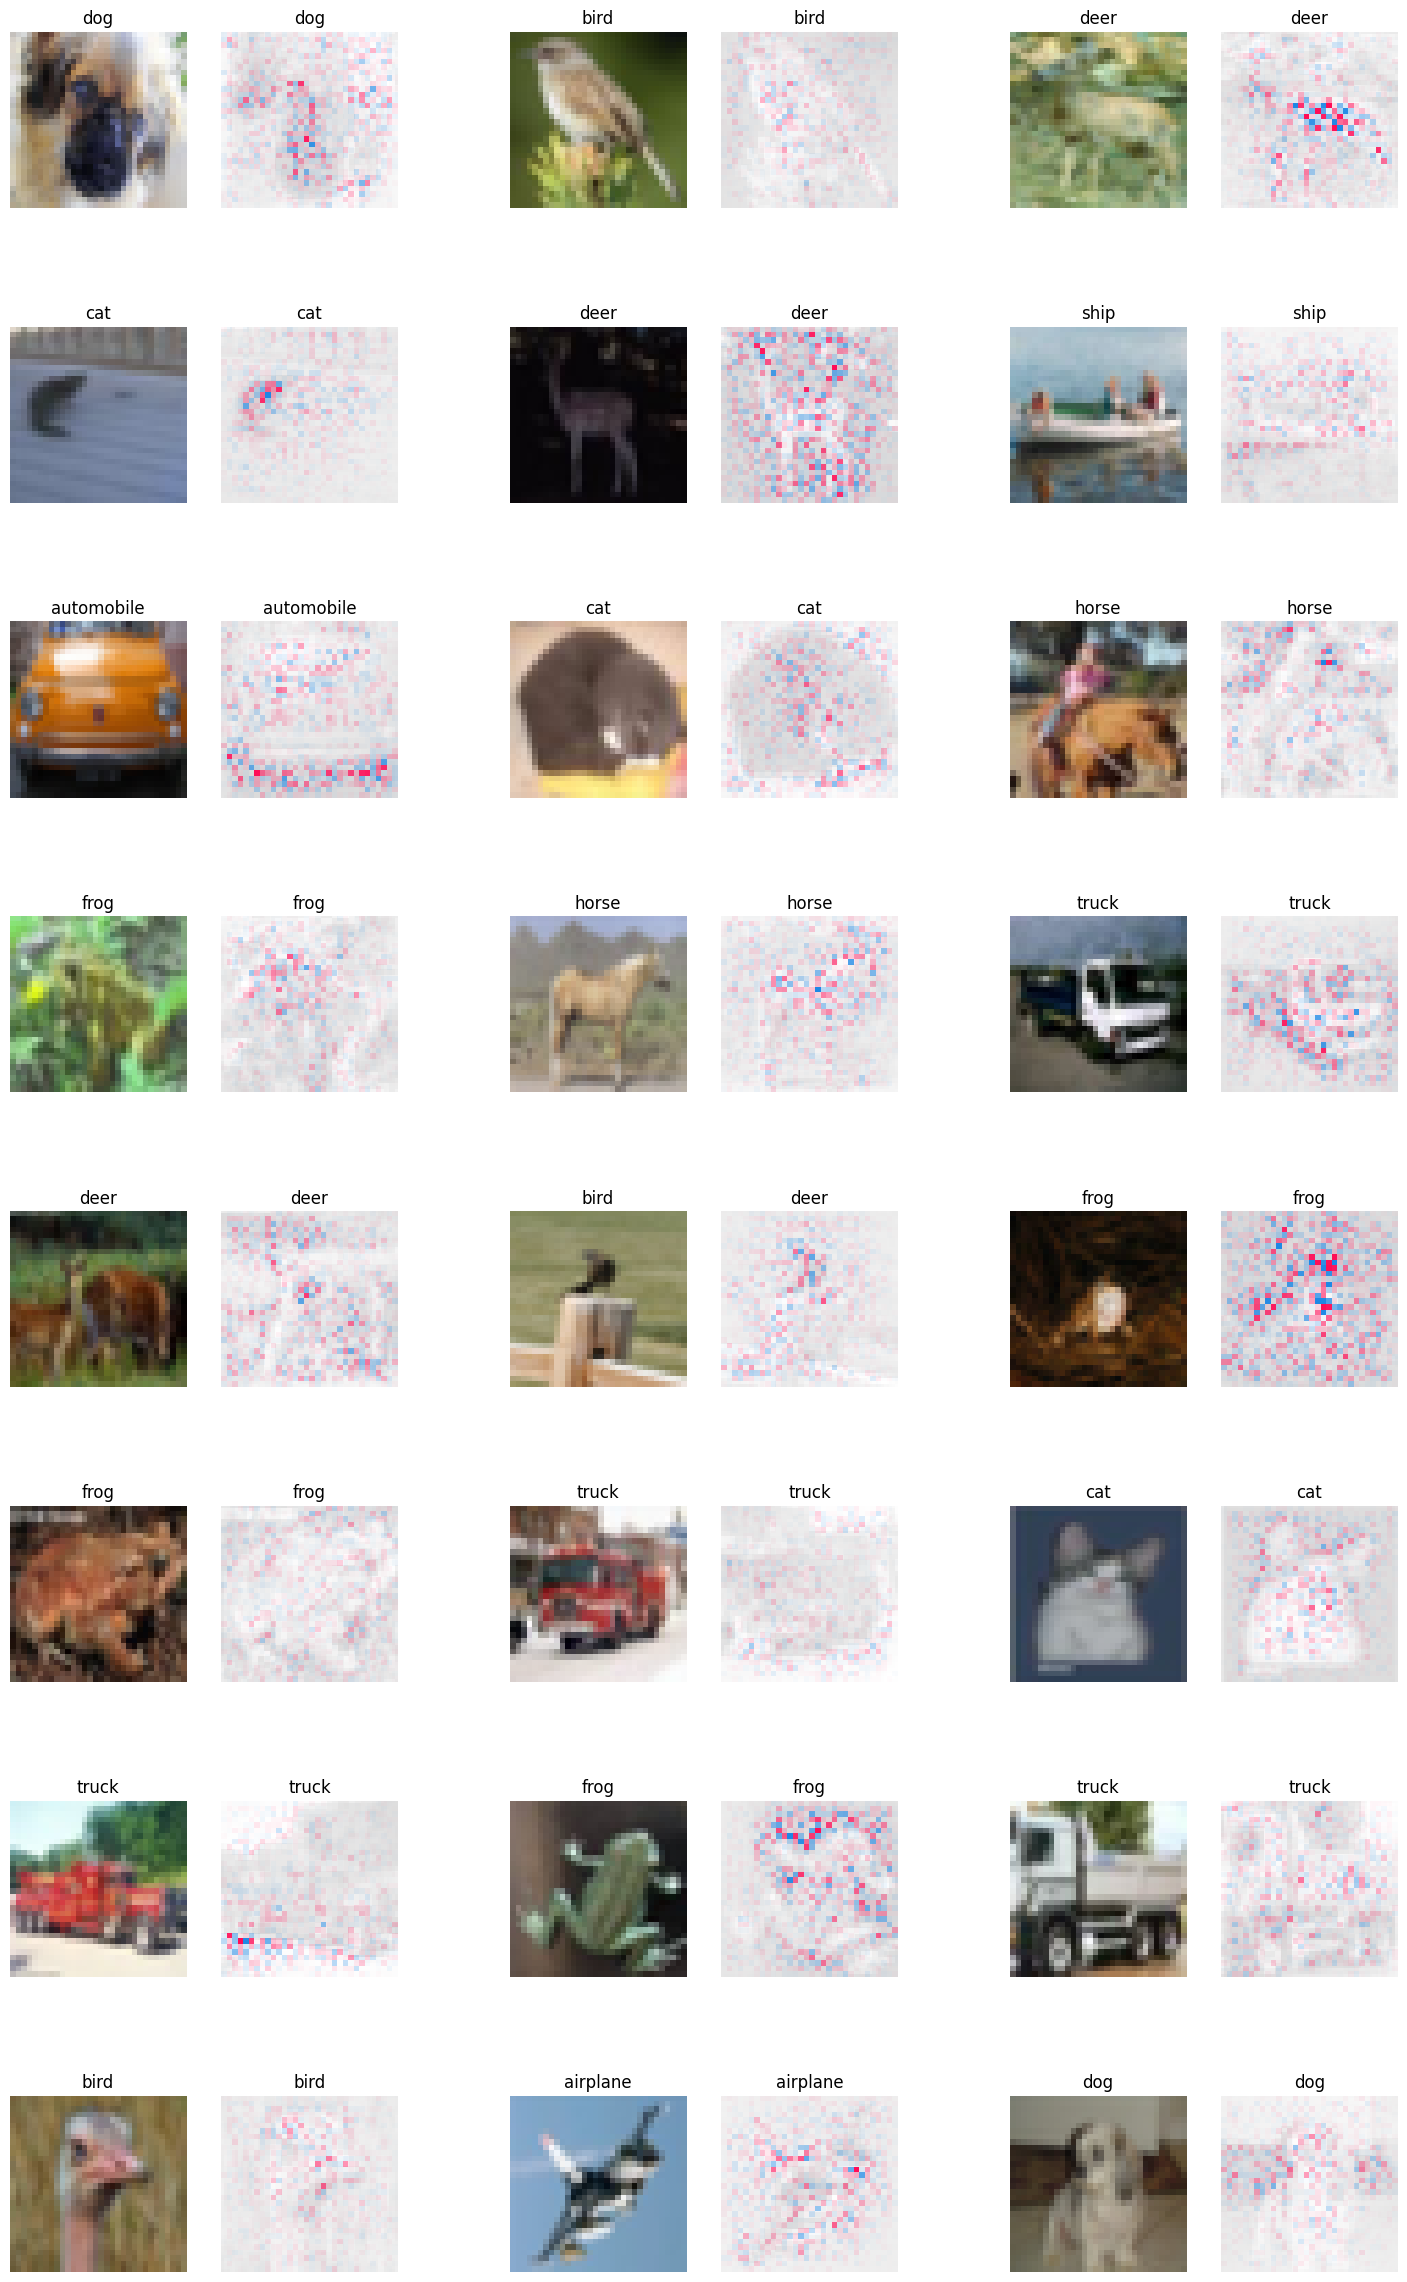

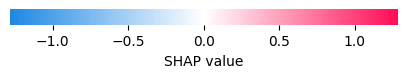

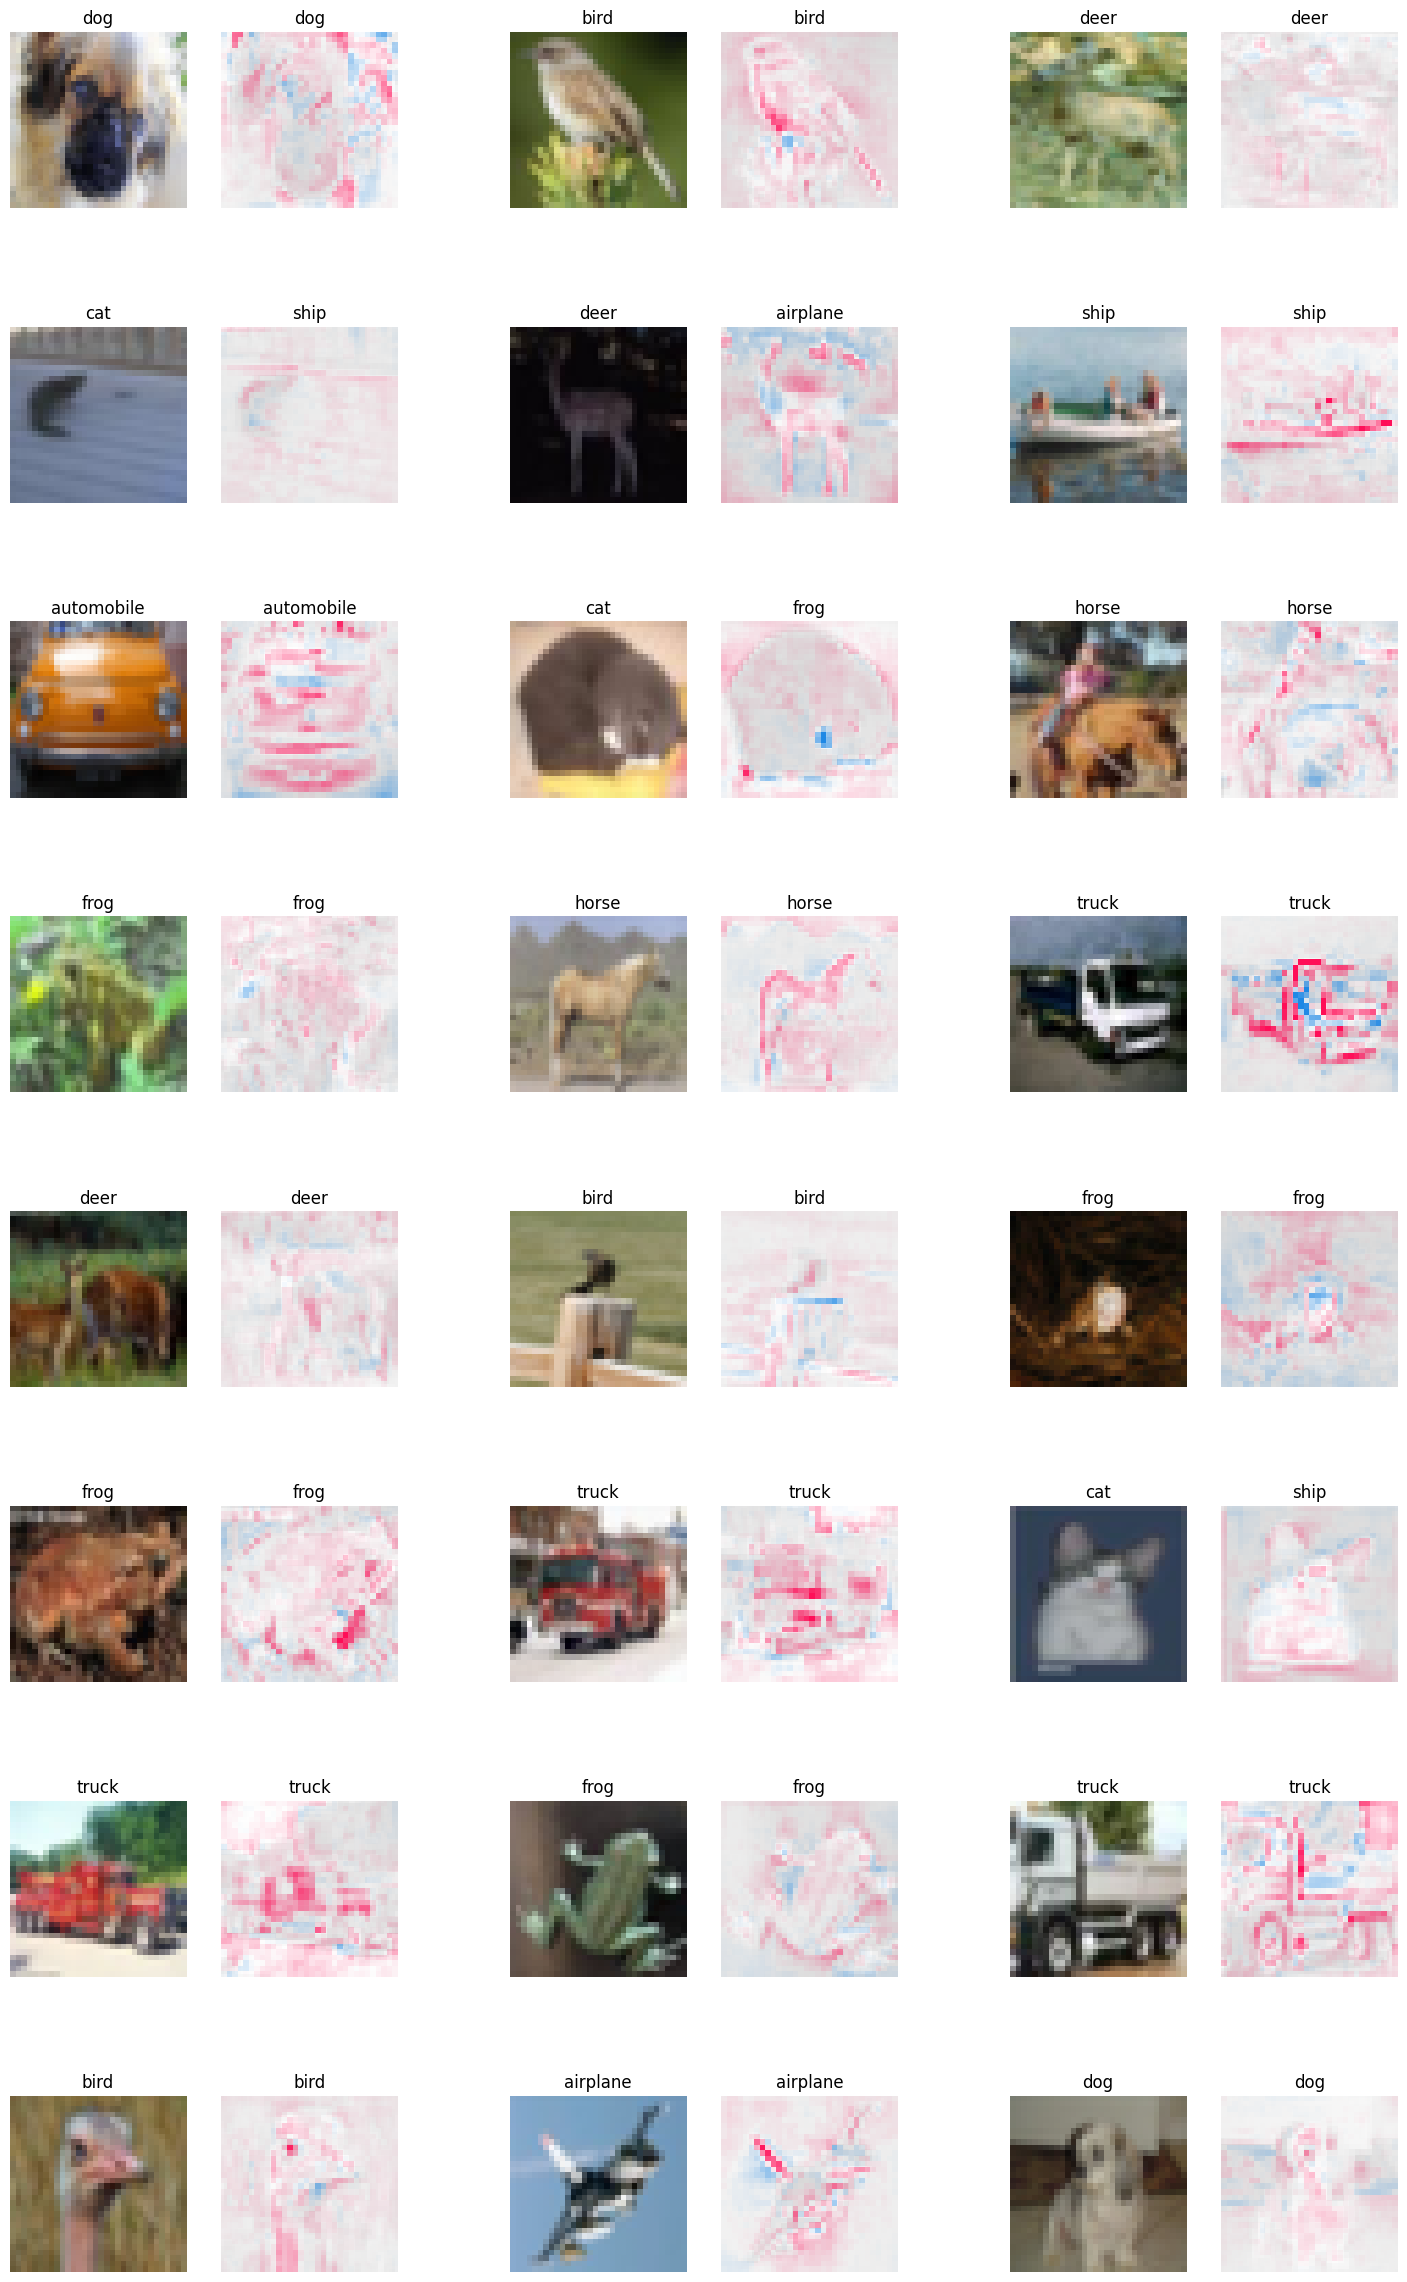

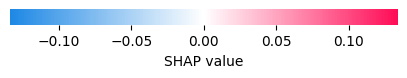

100%|██████████| 10/10 [00:02<00:00,  4.57trial/s, completeness=0.00189]


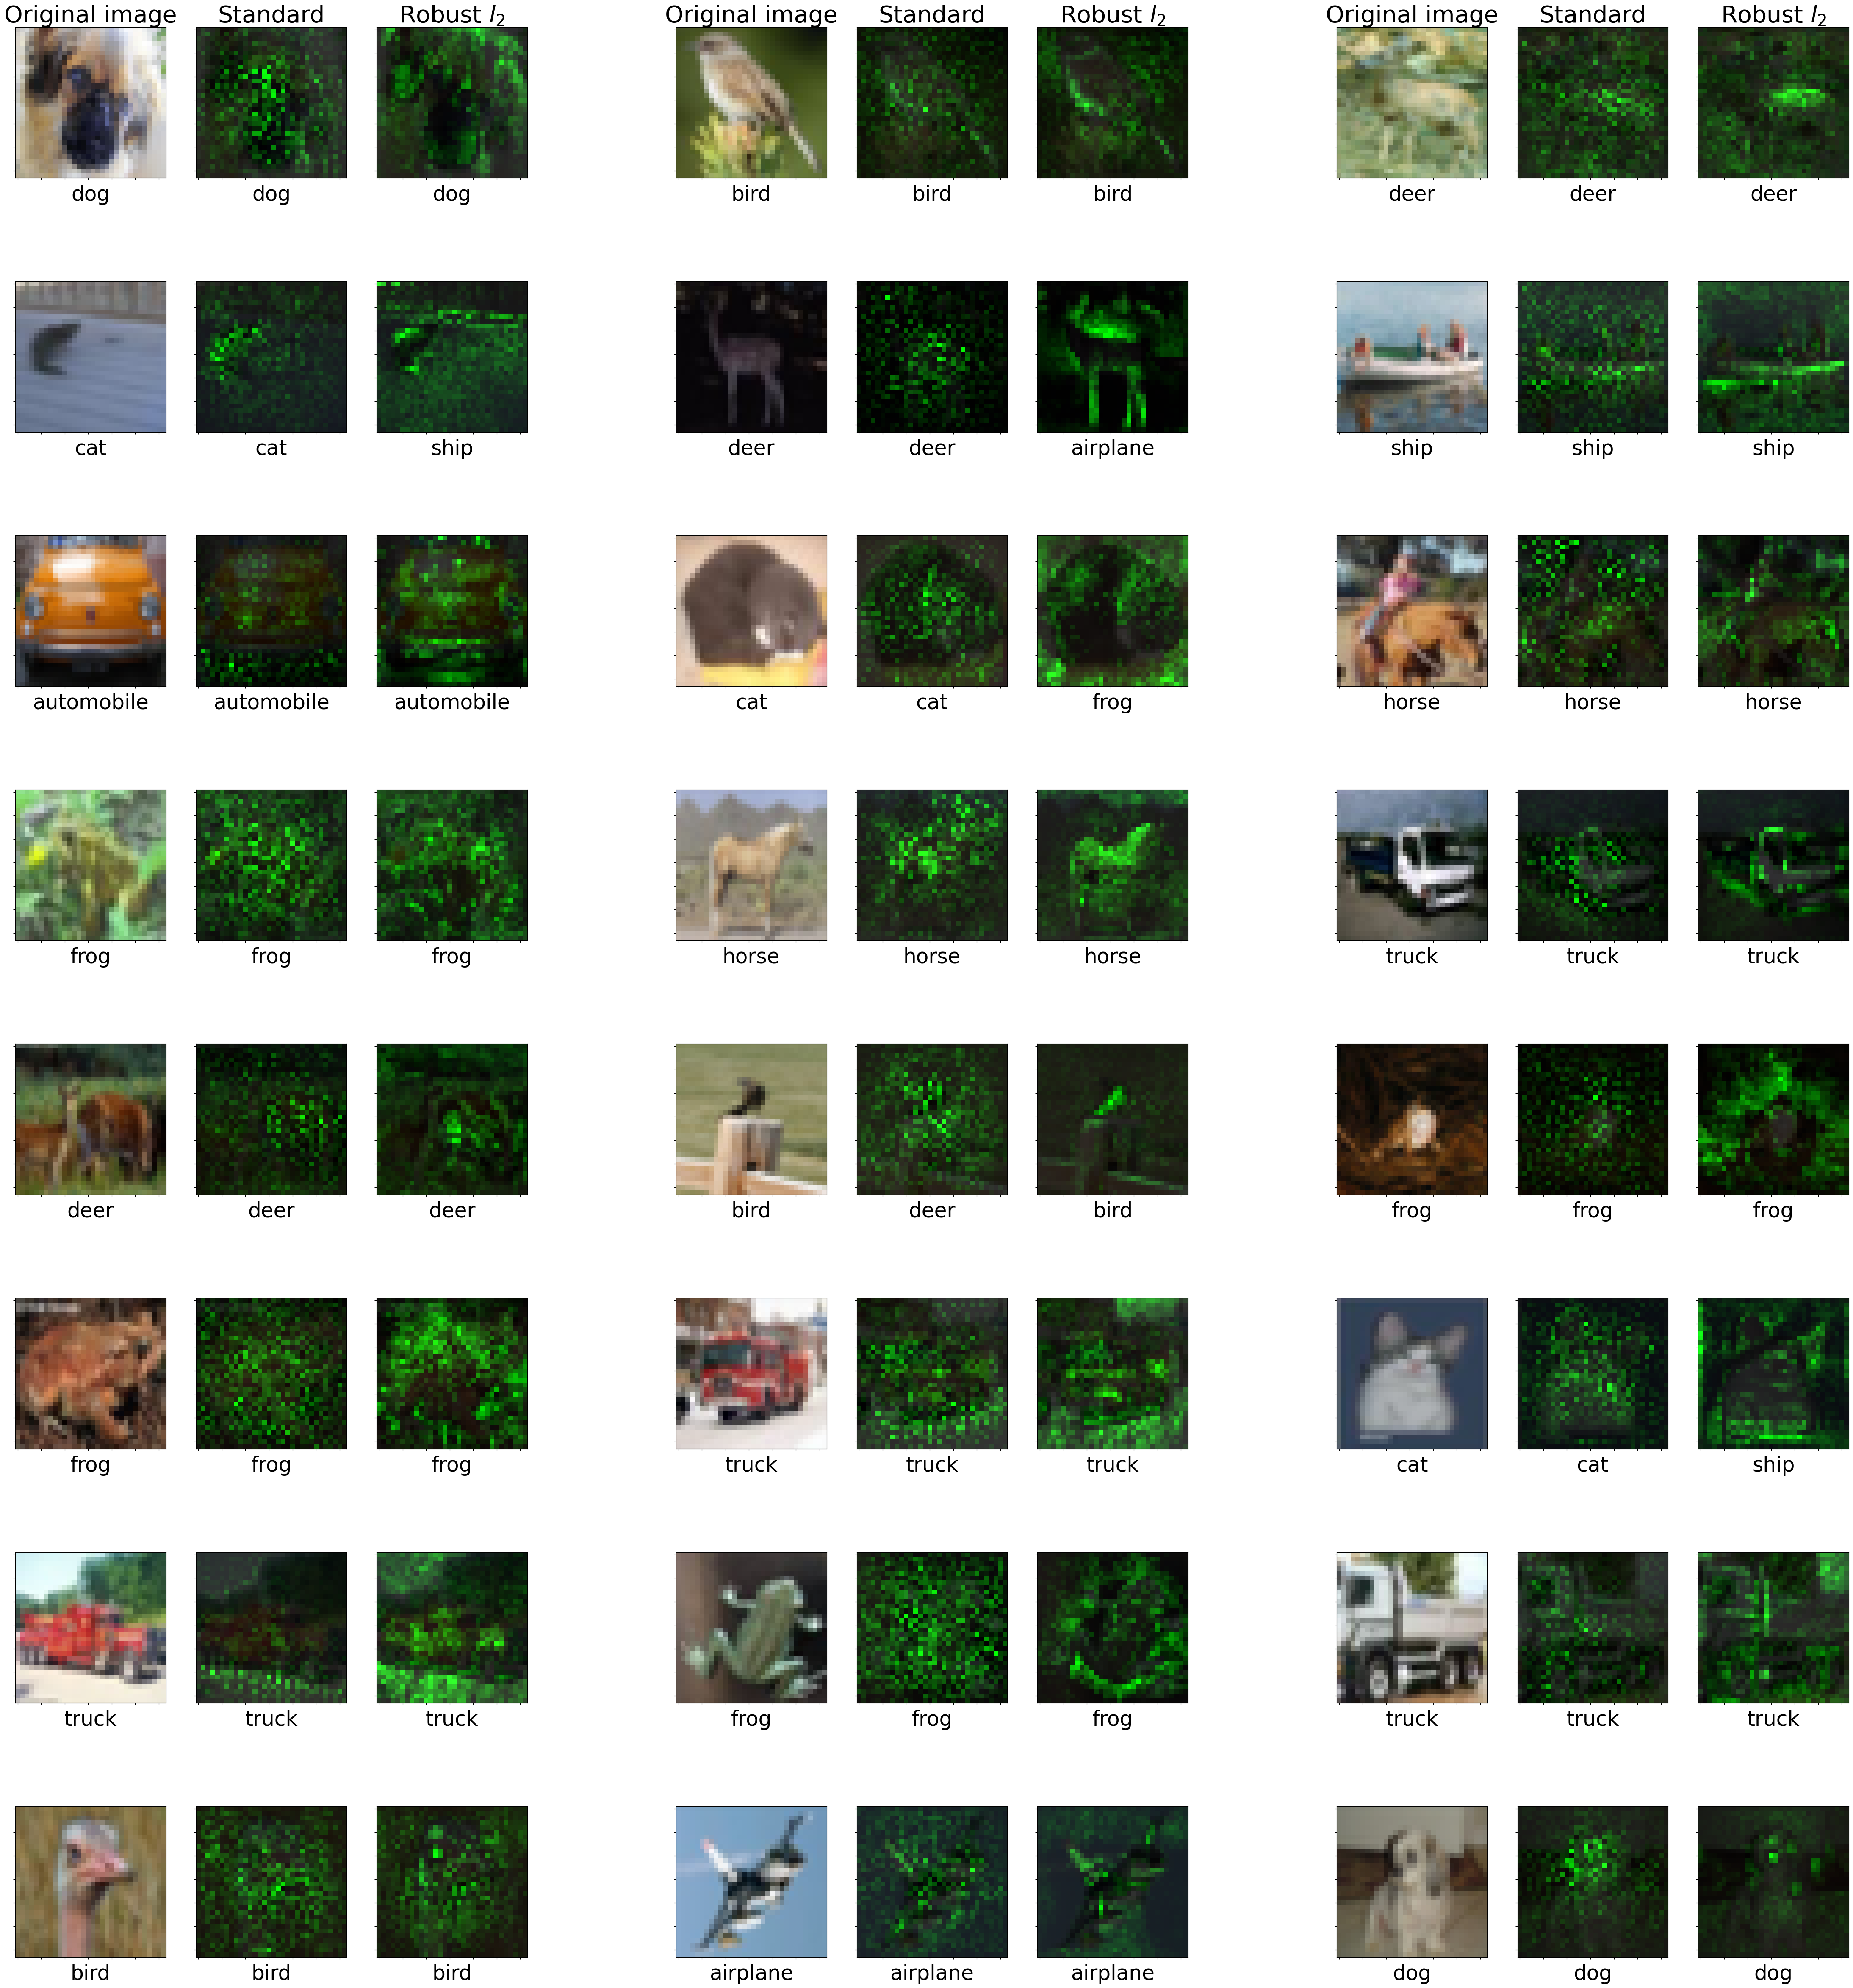

In [14]:
shapeval = ShapEval(model, classes, normalizer)
shapeval.gradient_exp(images[:176], images[176:200], labels[176:200])
shapeval2 = ShapEval(model2, classes, normalizer)
shapeval2.gradient_exp(images[:176], images[176:200], labels[176:200])
int_grads_compare_3(model, model2, images[176:200], labels[176:200], classes, normalizer)
plt.show()